# 1. Setup and Load Data

## 1.1. Imports and config GPU usage

In [66]:
import os
import cv2
import imghdr
import itertools

import numpy as np 
import tensorflow as tf
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

from matplotlib import pyplot as plt

In [67]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

Num GPUs Available:  1


## 1.2. Remove dodgy images

In [68]:
# # Setting the path to the directory containing datasets
# data_dir = '../datasets/train_test'

# # List of acceptable image extensions
# image_extensions = ['jpeg','jpg','bmp','png']

# # Looping through each dataset in the data directory
# for dataset in os.listdir(data_dir):
#     # Looping through each image in the current dataset
#     for image in os.listdir(os.path.join(data_dir, dataset)):
#         # Creating the path to the current image
#         image_path = os.path.join(data_dir, dataset, image)
        
#         try:
#             # Reading the image using OpenCV
#             img = cv2.imread(image_path)
#             # Checking the type of the image
#             tip = imghdr.what(image_path)

#             # If the image type is not in the list of acceptable image extensions
#             if tip not in image_extensions:
#                 # Printing a message indicating that the image is not in the list of extensions
#                 print('Image not in extensions list {}'.format(image_path))
#                 # Removing the image
#                 os.remove(image_path)
                
#         except Exception as e:
#             # Printing a message indicating there was an issue with the current image
#             print('Issue with image {}'.format(image_path))

## 1.3 Load data

In [69]:
train_data_dir = '../datasets/train_test/train_images/'
label_csv = '../datasets/train.csv'

# Read train.csv file
images_labels = pd.read_csv(label_csv)

In [70]:
# Encode competition-provided labels 
label_to_id = {
    'healthy': 0,
    'scab': 1,
    'frog_eye_leaf_spot': 2,
    'rust': 3,
    'complex': 4,
    'powdery_mildew': 5,
    'scab frog_eye_leaf_spot complex': 6,
    'scab frog_eye_leaf_spot': 7,
    'frog_eye_leaf_spot complex': 8,
    'rust frog_eye_leaf_spot': 9,
    'powdery_mildew complex': 10,
    'rust complex': 11
}

id_to_label = {value:key for key, value in label_to_id.items()} 

images_labels['labels'] = images_labels['labels'].map(label_to_id)

In [71]:
# Helper functions
def make_path(row):
    return  os.path.join(train_data_dir, row.image)

# Get absolute path for images
images_labels['image'] = images_labels.apply(lambda row: make_path(row), axis=1)

# Look at the dataframe
images_labels.head()

image  labels
0  ../datasets/train_test/train_images/800113bb65...       0
1  ../datasets/train_test/train_images/8002cb321f...       6
2  ../datasets/train_test/train_images/80070f7fb5...       1
3  ../datasets/train_test/train_images/8007751778...       1
4  ../datasets/train_test/train_images/800cbf0ff8...       4

In [72]:
# 6. Helper functions for input pipeline
def decode_image(image):
    # Convert the compressed string to a 3D uint8 tensor
    image = tf.image.decode_jpeg(image, channels=3)
    
    # Normalize image
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)

    # Resize image
    image = tf.image.resize(image, (255, 255))

    return image

def load_image(dict):
    # Load image
    image = tf.io.read_file(dict['image'])
    image = decode_image(image)
    
    # Parse label
    label = dict['labels']
    
    return image, label

# 7. Build data loaders
data = tf.data.Dataset.from_tensor_slices(dict(images_labels))
data = ( data.map(load_image).batch(32) )
data_iterator = data.as_numpy_iterator()

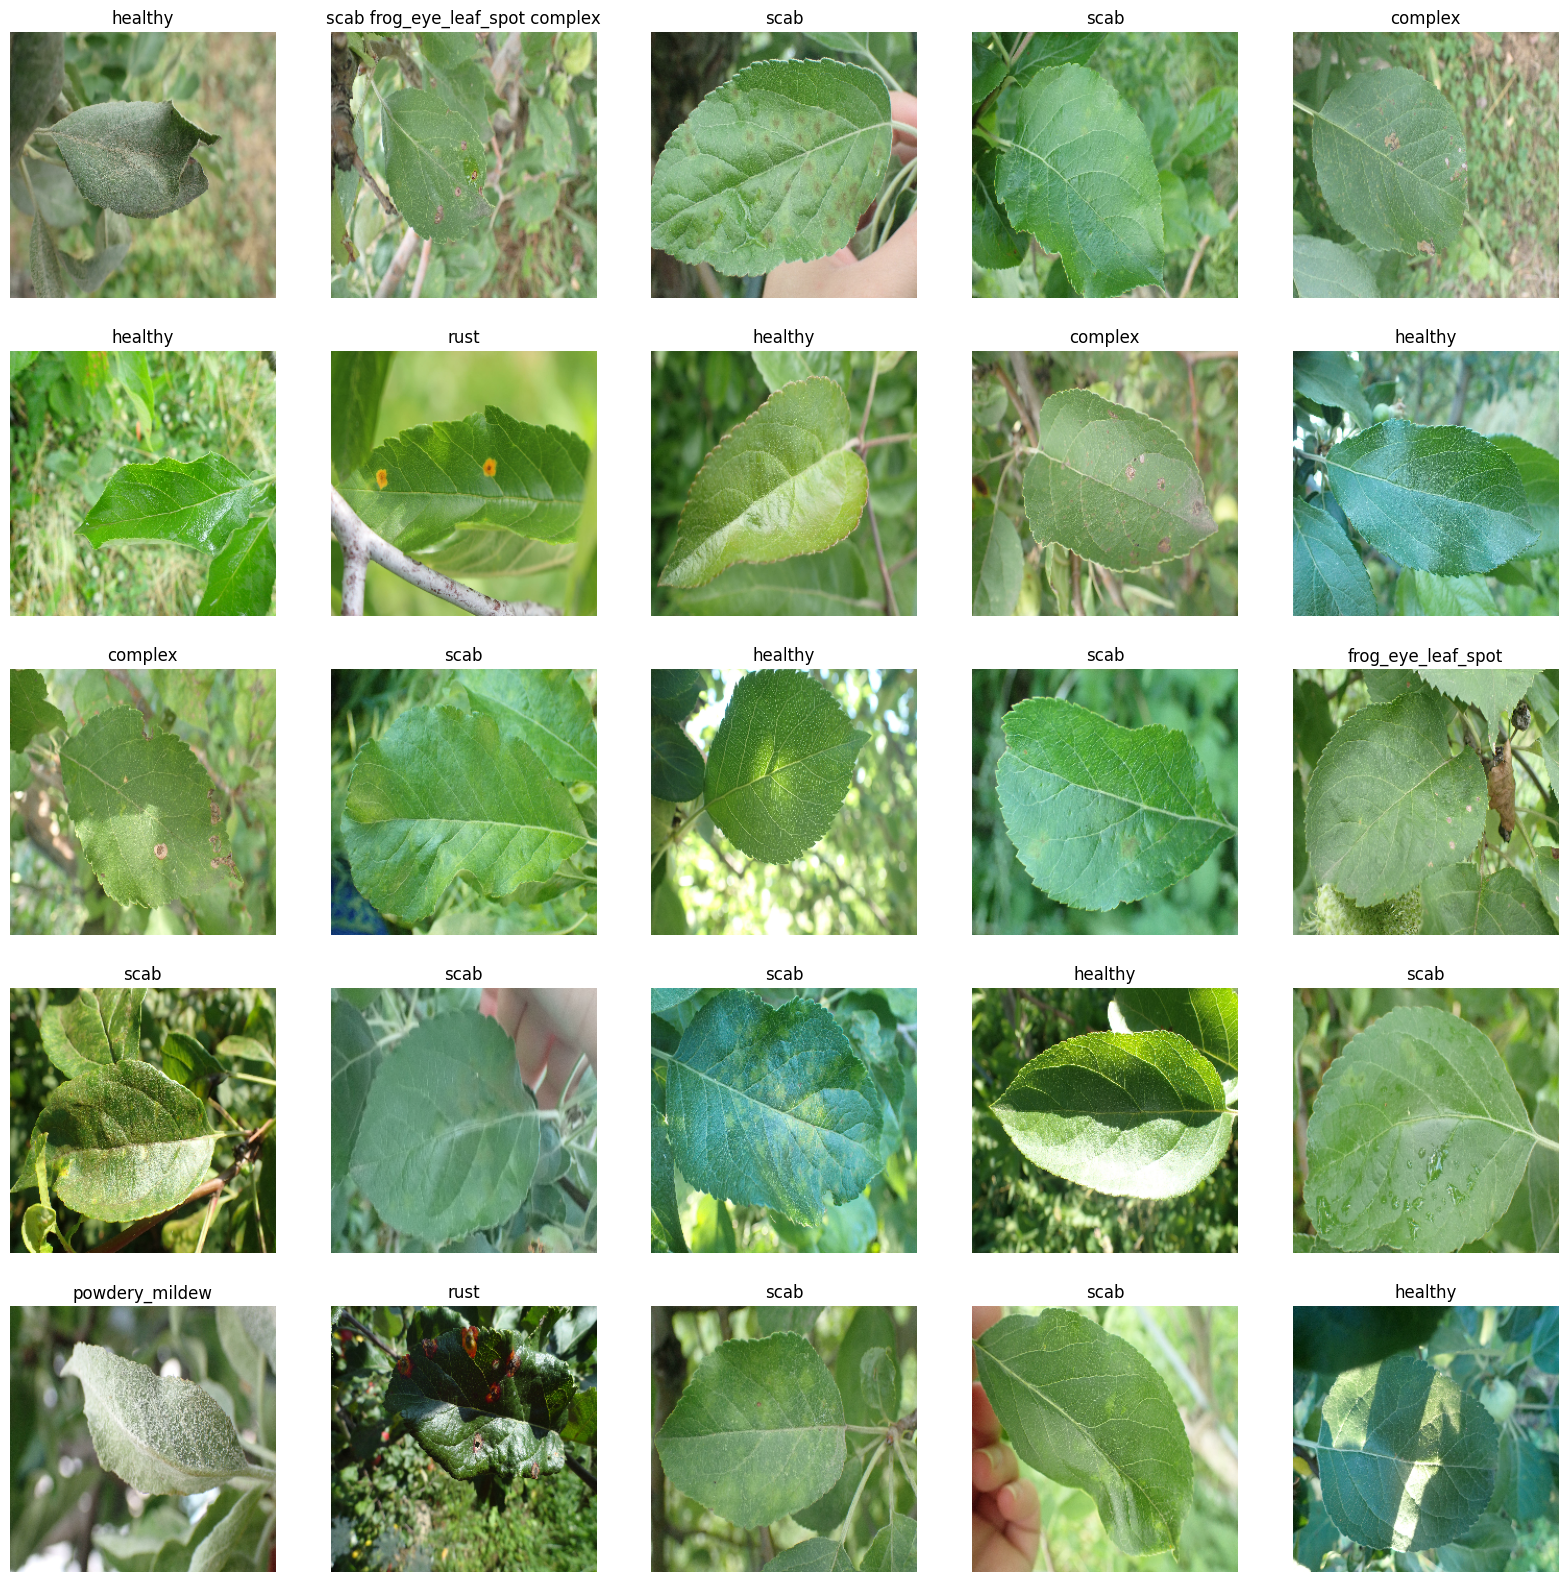

In [73]:
# Data loader sanity check
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(20,20))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(id_to_label[label_batch[n]])
        plt.axis('off')

image_batch, label_batch = data_iterator.next() #next(iter(data))
show_batch(image_batch, label_batch)

# 2.0. Preprocessing Data

## 2.1. Scale Data

In [75]:
data = data.map(lambda x, y: (x/255, y) )

## 2.2. Split Data

In [76]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 3.0. Deep Learning Model

## 3.1. Build CNN

In [81]:
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(255,255,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(12, activation='softmax')) 

In [82]:
model.compile('adam', loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [83]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 253, 253, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 126, 126, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 124, 124, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

## 3.2 Train

In [84]:
model.fit(train, epochs=20, validation_data=val)

Epoch 1/20


ValueError: in user code:

    File "c:\Users\Matheus Henrique\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Matheus Henrique\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Matheus Henrique\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\Matheus Henrique\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\Matheus Henrique\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "c:\Users\Matheus Henrique\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\Matheus Henrique\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\Matheus Henrique\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\Matheus Henrique\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 1990, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "c:\Users\Matheus Henrique\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py", line 5529, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 12) are incompatible
